In [35]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import feature_util_UPFall
import seaborn as sns
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I - Unfiltered

In [36]:
df = pd.read_csv("New Datasets/UPFallWristData.csv")
df


,acc_x_axis,acc_y_axis,acc_z_axis,ang_vel_x_axis,ang_vel_y_axis,ang_vel_z_axis,Activity,Trial,Tag
0,-1.240,-0.557,0.227,-75.854,44.024,315.915,1,1,7
1,-1.240,-0.557,0.227,-28.780,55.549,344.146,1,1,7
2,-1.884,-0.687,0.251,27.256,87.134,372.012,1,1,7
3,-1.884,-0.687,0.251,2.866,117.683,356.463,1,1,7
4,-1.597,-0.646,0.112,10.000,30.671,126.768,1,1,7
...,...,...,...,...,...,...,...,...,...
294673,0.310,0.545,0.835,1.220,3.537,-1.220,11,3,11
294674,0.304,0.549,0.833,0.976,2.317,-1.159,11,3,11
294675,0.318,0.555,0.824,3.598,2.866,-1.402,11,3,11
294676,0.321,0.561,0.822,-0.183,2.073,0.000,11,3,11


<AxesSubplot: >

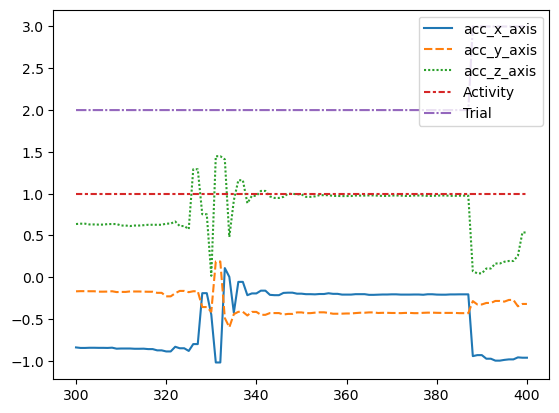

In [37]:
sns.lineplot(data=df[(df['Activity'] == 1)].loc[300:400, ['acc_x_axis', 'acc_y_axis', 'acc_z_axis', 'Activity', 'Trial']])

In [38]:
df_falls_renamed = df.copy()
df_falls_renamed.loc[(df_falls_renamed['Activity'] == 2) |
                     (df_falls_renamed['Activity'] == 3) |
                     (df_falls_renamed['Activity'] == 4) |
                     (df_falls_renamed['Activity'] == 5),
                     'Activity'] = 1

df_falls_renamed['Activity'].value_counts()

6     54568
7     54032
8     53689
11    50872
1     45951
10    26694
9      8872
Name: Activity, dtype: int64

In [39]:
df_binary = df_falls_renamed.copy()
df_binary.loc[(df_binary['Activity'] == 6) |
                     (df_binary['Activity'] == 7) |
                     (df_binary['Activity'] == 8) |
                     (df_binary['Activity'] == 9) |
                     (df_binary['Activity'] == 10) |
                     (df_binary['Activity'] == 11),
                     'Activity'] = 0
df_binary['Activity'].value_counts()

0    248727
1     45951
Name: Activity, dtype: int64

In [40]:
Fs = 18.4 # Hz
frame_size = int(Fs * 5) # 100 Hz and 2s window
hop_size = int(frame_size * 0.5) # 50% overlap
# hop_size = int(frame_size * 1) # 50% overlap

In [41]:
# df_ticwatch = pd.read_csv("New Datasets/ticwatch_dataset_gyro.csv", index_col=0)
# df_ticwatch = df_ticwatch.drop(columns=['timestamp'], axis=1)
# df_ticwatch['outcome'] = 0
# df_ticwatch

In [42]:
df_binary = df_binary.drop(columns=['Trial', 'Tag'])
df_binary = df_binary.rename(mapper={'acc_x_axis':'acc_x',
                                     'acc_y_axis':'acc_y',
                                     'acc_z_axis':'acc_z',
                                     'ang_vel_x_axis':'gyro_x',
                                     'ang_vel_y_axis':'gyro_y',
                                     'ang_vel_z_axis':'gyro_z',
                                     'Activity':'outcome'}, axis=1)

In [43]:
# df_binary_combined_unfiltered = pd.concat([df_binary, df_ticwatch]).reset_index(drop=True)
# df_binary_combined_unfiltered
df_binary_combined_unfiltered = df_binary
df_binary_combined_unfiltered
# df_binary_combined_filtered = feature_util_UPFall.apply_filter(df_binary_combined.drop(columns=['outcome']), Fs)
# df_binary_combined_filtered['outcome'] = df_binary_combined['outcome']

binary_frames, y_binary = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_unfiltered, frame_size, hop_size, True)
binary_features = feature_util_UPFall.extract_features_with_gyro(binary_frames)
binary_features_df = pd.DataFrame(binary_features)
y_binary_df = pd.DataFrame(y_binary, columns=['outcome'])
binary_features_and_outcome = pd.concat([binary_features_df, y_binary_df], axis=1)

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


In [44]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_unfiltered_res, y_unfiltered_res = sm.fit_resample(binary_features_df, y_binary_df)
y_unfiltered_res.value_counts()

outcome
0          5406
1          5406
dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_unfiltered_res, y_unfiltered_res, test_size=0.25, random_state=0, stratify=y_unfiltered_res)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8109, 22), (2703, 22), (8109, 1), (2703, 1))

In [47]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 4054, 1: 4055}

### Traditional Machine Learning Methods

In [48]:
model_name_array = []
model_acc_array = []

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [51]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [52]:
# Predict on the test set
predicted = knn_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted))
print(accuracy_score(y_test, predicted))
print(f1_score(y_test, predicted, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
model_name_array.append("knn")
model_acc_array.append(accuracy_score(y_test, predicted))

[[1183  169]
 [  37 1314]]
0.9237883832778394
0.9237883832778394


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [53]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [54]:
from sklearn import svm

In [55]:
svm_model = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [56]:
# Predict on the test set
predicted_svm = svm_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_svm))
print(accuracy_score(y_test, predicted_svm))
print(f1_score(y_test, predicted_svm, average='micro'))

model_name_array.append("svm")
model_acc_array.append(accuracy_score(y_test, predicted_svm))

[[1031  321]
 [ 483  868]]
0.7025527192008879
0.7025527192008879


In [57]:
svm_rbf_model = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [58]:
# Predict on the test set
predicted_svm_rbf = svm_rbf_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_svm_rbf))
print(accuracy_score(y_test, predicted_svm_rbf))
print(f1_score(y_test, predicted_svm_rbf, average='micro'))
model_name_array.append("svm_rbf")
model_acc_array.append(accuracy_score(y_test, predicted_svm_rbf))


[[1222  130]
 [ 535  816]]
0.7539770625231225
0.7539770625231226


In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_29220\2856838272.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [61]:
# Predict on the test set
predicted_rf = rf_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_rf))
print(accuracy_score(y_test, predicted_rf))
print(f1_score(y_test, predicted_rf, average='micro'))
model_name_array.append("rf")
model_acc_array.append(accuracy_score(y_test, predicted_rf))

[[1228  124]
 [  45 1306]]
0.9374768775434702
0.9374768775434702


In [62]:
from sklearn.naive_bayes import GaussianNB

In [63]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [64]:
# Predict on the test set
predicted_nb = nb_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_nb))
print(accuracy_score(y_test, predicted_nb))
print(f1_score(y_test, predicted_nb, average='micro'))
model_name_array.append("nb")
model_acc_array.append(accuracy_score(y_test, predicted_nb))


[[1211  141]
 [ 698  653]]
0.6896041435442102
0.6896041435442102


In [65]:
best_trad_model_acc = max(model_acc_array)
index = model_acc_array.index(max(model_acc_array))
best_trad_model = model_name_array[index]
print(f"Best model: {best_trad_model}, Accuracy: {best_trad_model_acc}")
# model_acc_array

Best model: rf, Accuracy: 0.9374768775434702


In [66]:
for i in range(0, len(model_name_array)):
    print(f"name: {model_name_array[i]}, accuracy: {model_acc_array[i]}")

name: knn, accuracy: 0.9237883832778394
name: svm, accuracy: 0.7025527192008879
name: svm_rbf, accuracy: 0.7539770625231225
name: rf, accuracy: 0.9374768775434702
name: nb, accuracy: 0.6896041435442102


In [67]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 4054, 1: 4055}

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [69]:
unfiltered_model_dictionary = {"knn": knn_model,
                             "svm": svm_model,
                             "svm_rbf": svm_rbf_model,
                             "rf": rf_model,
                             "nb": nb_model}

In [70]:
def perform_cross_val_all_models(model_dictionary, X_train, y_train, num_folds=5):
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores_array = []

    for model_name in model_dictionary:
        model = model_dictionary[model_name]
        scores = cross_val_score(model, X_train, y_train, cv=cv)
        scores_array.append((model_name, scores))
    
    return scores_array

In [71]:
scores_array = perform_cross_val_all_models(unfiltered_model_dictionary, X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [72]:
for cv_tuple in scores_array:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.91 (+/- 0.00)
svm Accuracy: 0.71 (+/- 0.02)
svm_rbf Accuracy: 0.76 (+/- 0.02)
rf Accuracy: 0.93 (+/- 0.01)
nb Accuracy: 0.69 (+/- 0.03)


In [73]:
from sklearn.metrics import classification_report

In [74]:
def print_all_classification_reports(model_dictionary, X_test, y_test): # broken!!! only works for filtered data. TODO: change X_test and y_test to params
        for model_name in model_dictionary:
                print("Classification report for %s" % model_name)
                model = model_dictionary[model_name]
                predicted = model.predict(X_test)
                print(classification_report(y_test, predicted))
                print("=====================================================")

In [75]:
print_all_classification_reports(unfiltered_model_dictionary, X_test, y_test)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1352
           1       0.89      0.97      0.93      1351

    accuracy                           0.92      2703
   macro avg       0.93      0.92      0.92      2703
weighted avg       0.93      0.92      0.92      2703

Classification report for svm
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1352
           1       0.73      0.64      0.68      1351

    accuracy                           0.70      2703
   macro avg       0.71      0.70      0.70      2703
weighted avg       0.71      0.70      0.70      2703

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      1352
           1       0.86      0.60      0.71      1351

    accuracy                           0.75      2703
   macro avg       0.78      0.75      0.75      2703
weighted a

In [76]:
def print_all_classification_reports_training(model_dictionary, X_train, y_train):
        for model_name in model_dictionary:
                print("Classification report for %s" % model_name)
                model = model_dictionary[model_name]
                predicted = model.predict(X_train)
                print(classification_report(y_train, predicted))
                print("=====================================================")

In [77]:
print_all_classification_reports_training(unfiltered_model_dictionary, X_train, y_train)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4054
           1       0.91      0.99      0.95      4055

    accuracy                           0.95      8109
   macro avg       0.95      0.95      0.95      8109
weighted avg       0.95      0.95      0.95      8109

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      4054
           1       0.73      0.66      0.70      4055

    accuracy                           0.71      8109
   macro avg       0.71      0.71      0.71      8109
weighted avg       0.71      0.71      0.71      8109

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      4054
           1       0.87      0.62      0.72      4055

    accuracy                           0.76      8109
   macro avg       0.79      0.76      0.76      8109
weighted a

In [208]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/EXP4_RF_UNFILTERED_FIXED.joblib')
# dump(rf_model, 'Final Models/exp4_rf_unfiltered.joblib')
# dump(knn_model, 'Final Models/exp4_knn_unfiltered.joblib')

['Final Models/exp4_knn_unfiltered.joblib']

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [79]:
binary_frames.shape, y_binary.shape

((6405, 92, 6), (6405,))

In [80]:
X_raw_smote, y_raw_smote = feature_util_UPFall.generate_windows_SMOTE(binary_frames, y_binary)
X_raw_smote.shape, y_raw_smote.shape

((10812, 92, 6), (10812,))

In [81]:
# X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(binary_frames, y_binary, test_size=0.25, random_state=0, stratify=y_binary)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw_smote, y_raw_smote, test_size=0.25, random_state=0, stratify=y_raw_smote)
X_raw_train.shape, X_raw_test.shape, y_raw_train.shape

((8109, 92, 6), (2703, 92, 6), (8109,))

In [82]:
X_raw_train[0].shape

(92, 6)

In [83]:
# X_TRAIN_SIZE = 2268
# X_TEST_SIZE = 757
X_TRAIN_SIZE = X_raw_train.shape[0]
X_TEST_SIZE = X_raw_test.shape[0]
X_TRAIN_WINDOW_SIZE = X_raw_train.shape[1]
X_TEST_WINDOW_SIZE = X_raw_test.shape[1]

In [84]:
X_raw_train = X_raw_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_test = X_raw_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [85]:
X_raw_train[0].shape, X_raw_test[0].shape

((92, 6, 1), (92, 6, 1))

In [86]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [87]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_train[0].shape))
cnn_model.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(2, activation='softmax'))

In [88]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
NUMBER_OF_EPOCHS = 15

In [90]:
history = cnn_model.fit(X_raw_train, y_raw_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_test, y_raw_test), verbose=1)

Epoch 1/15
254/254 [==============================] - 5s 17ms/step - loss: 0.4552 - accuracy: 0.7786 - val_loss: 0.3396 - val_accuracy: 0.8431
Epoch 2/15
254/254 [==============================] - 4s 16ms/step - loss: 0.2974 - accuracy: 0.8697 - val_loss: 0.3141 - val_accuracy: 0.8539
Epoch 3/15
254/254 [==============================] - 4s 15ms/step - loss: 0.2345 - accuracy: 0.9042 - val_loss: 0.2583 - val_accuracy: 0.8912
Epoch 4/15
254/254 [==============================] - 4s 14ms/step - loss: 0.1934 - accuracy: 0.9193 - val_loss: 0.2130 - val_accuracy: 0.9267
Epoch 5/15
254/254 [==============================] - 4s 14ms/step - loss: 0.1679 - accuracy: 0.9312 - val_loss: 0.2255 - val_accuracy: 0.9238
Epoch 6/15
254/254 [==============================] - 4s 16ms/step - loss: 0.1385 - accuracy: 0.9472 - val_loss: 0.2051 - val_accuracy: 0.9316
Epoch 7/15
254/254 [==============================] - 4s 16ms/step - loss: 0.1199 - accuracy: 0.9550 - val_loss: 0.2031 - val_accuracy: 0.9364

In [91]:
import matplotlib.pyplot as plt

In [92]:
def plot_learning_curve(history, epochs):
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

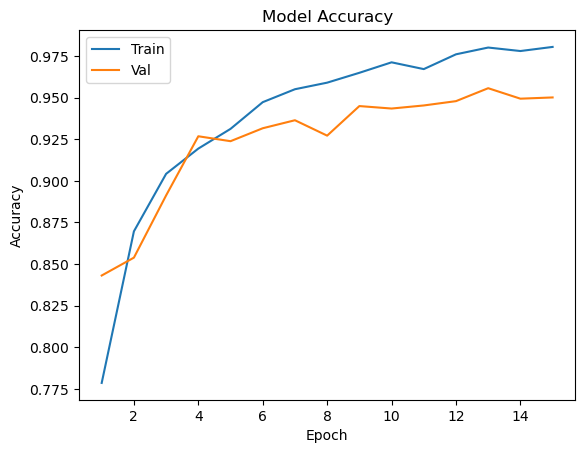

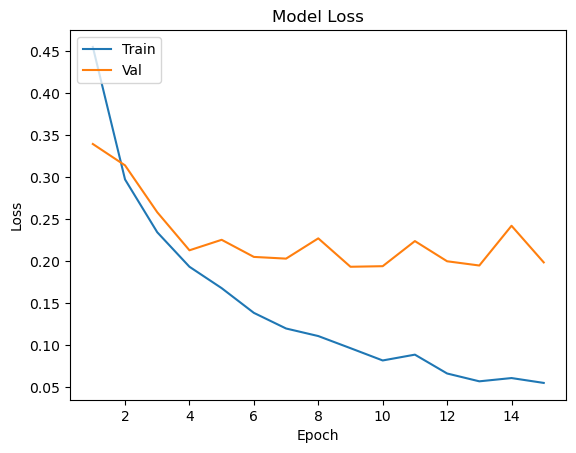

In [93]:
plot_learning_curve(history, NUMBER_OF_EPOCHS)

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

In [95]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn = np.argmax(cnn_model.predict(X_raw_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_test, predicted_cnn))
print(accuracy_score(y_raw_test, predicted_cnn))
print(f1_score(y_raw_test, predicted_cnn, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

85/85 [==============================] - 0s 3ms/step
[[1295   57]
 [  78 1273]]
0.9500554938956715
0.9500554938956715


In [96]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_test, predicted_cnn))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1352
           1       0.96      0.94      0.95      1351

    accuracy                           0.95      2703
   macro avg       0.95      0.95      0.95      2703
weighted avg       0.95      0.95      0.95      2703



In [97]:
# results = cnn_model.evaluate(X_raw_test, y_raw_test)
# print("test loss, test acc: ", results)

In [ ]:
cnn_unfiltered_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_train, y_raw_train, X_raw_train[0].shape, NUMBER_OF_EPOCHS, 5)

In [ ]:
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_unfiltered_cv_metrics)

0.936365258693695


In [207]:
# cnn_model.save('Final Models/exp4_cnn_unfiltered')

INFO:tensorflow:Assets written to: Final Models/exp4_cnn_unfiltered\assets


INFO:tensorflow:Assets written to: Final Models/exp4_cnn_unfiltered\assets


## II - Filtered

In [98]:
df_binary_combined_filtered = feature_util_UPFall.apply_filter(df_binary_combined_unfiltered.drop(['outcome'], axis=1), Fs)
df_binary_combined_filtered['outcome'] = df_binary_combined_unfiltered['outcome']
df_binary_combined_filtered

low cutoff 5 Hz


,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,outcome
0,-1.239993,-0.557012,0.227003,-75.855628,44.024217,315.910160,1
1,-1.395815,-0.573027,0.244548,-17.510872,63.490971,354.156199,1
2,-1.744661,-0.682261,0.253276,7.506246,90.429294,380.509092,1
3,-1.917599,-0.711281,0.212457,15.604800,93.930676,321.103727,1
4,-1.600448,-0.537416,0.154293,21.432435,60.552806,162.230385,1
...,...,...,...,...,...,...,...
294673,0.302927,0.548072,0.835784,0.751494,3.327992,-1.311439,0
294674,0.307568,0.548625,0.831561,1.894530,2.672211,-1.305462,0
294675,0.318312,0.555836,0.825309,2.196824,2.538146,-0.837104,0
294676,0.319360,0.559022,0.821402,0.958866,2.235342,-0.590168,0


In [99]:
X_filtered, y_filtered = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_filtered, frame_size, hop_size, True)
features_filtered = feature_util_UPFall.extract_features_with_gyro(X_filtered)
features_filtered.shape

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


(6405, 22)

In [100]:
feature_filtered_df = pd.DataFrame(features_filtered)

y_filtered_df = pd.DataFrame(y_filtered)
y_filtered_df = y_filtered_df.rename(mapper={0:"outcome"}, axis=1)
y_filtered_df
feature_and_outcome_filtered_df = pd.concat([feature_filtered_df, y_filtered_df], axis=1)

In [101]:
sm = SMOTE(random_state=42)

X_filtered_res, y_filtered_res = sm.fit_resample(feature_filtered_df, y_filtered_df)
y_filtered_res.value_counts()

outcome
0          5406
1          5406
dtype: int64

In [102]:
X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered_res, y_filtered_res, test_size=0.25, random_state=0, stratify=y_filtered_res)

In [103]:
X_filtered_train.shape, X_filtered_test.shape, y_filtered_train.shape, y_filtered_test.shape

((8109, 22), (2703, 22), (8109, 1), (2703, 1))

In [104]:
unique, counts = np.unique(y_filtered_train, return_counts=True)
dict(zip(unique, counts))

{0: 4054, 1: 4055}

### Traditional Machine Learning Methods

In [105]:
filtered_model_name_array = []
filtered_model_acc_array = []

In [106]:
knn_model_filtered = KNeighborsClassifier(n_neighbors=5)
knn_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [107]:
# Predict on the test set
predicted_knn_filtered = knn_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_knn_filtered))
print(accuracy_score(y_filtered_test, predicted_knn_filtered))
print(f1_score(y_filtered_test, predicted_knn_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("knn")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_knn_filtered))

[[1184  168]
 [  47 1304]]
0.9204587495375509
0.9204587495375509


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [108]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [109]:
svm_model_filtered = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [110]:
# Predict on the test set
predicted_svm_filtered = svm_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_svm_filtered))
print(accuracy_score(y_filtered_test, predicted_svm_filtered))
print(f1_score(y_filtered_test, predicted_svm_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("svm")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_svm_filtered))

[[970 382]
 [432 919]]
0.6988531261561228
0.6988531261561228


In [111]:
svm_rbf_model_filtered = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [112]:
# Predict on the test set
predicted_svm_rbf_filtered = svm_rbf_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_svm_rbf_filtered))
print(accuracy_score(y_filtered_test, predicted_svm_rbf_filtered))
print(f1_score(y_filtered_test, predicted_svm_rbf_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("svm_rbf")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_svm_rbf_filtered))

[[1202  150]
 [ 510  841]]
0.755826859045505
0.7558268590455051


In [113]:
rf_model_filtered = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model_filtered.fit(X_filtered_train, y_filtered_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_29220\3673001609.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_filtered.fit(X_filtered_train, y_filtered_train)


RandomForestClassifier(random_state=42)

In [114]:
# Predict on the test set
predicted_rf_filtered = rf_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_rf_filtered))
print(accuracy_score(y_filtered_test, predicted_rf_filtered))
print(f1_score(y_filtered_test, predicted_rf_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("rf")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_rf_filtered))

[[1245  107]
 [  48 1303]]
0.9426563078061413
0.9426563078061412


In [115]:
nb_model_filtered = GaussianNB()
nb_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [116]:
# Predict on the test set
predicted_nb_filtered = nb_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_nb_filtered))
print(accuracy_score(y_filtered_test, predicted_nb_filtered))
print(f1_score(y_filtered_test, predicted_nb_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("nb")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_nb_filtered))

[[1144  208]
 [ 612  739]]
0.6966333703292638
0.6966333703292638


In [117]:
best_trad_model_acc_filtered = max(filtered_model_acc_array)
index = filtered_model_acc_array.index(max(filtered_model_acc_array))
best_trad_model_filtered = filtered_model_name_array[index]
print(f"Best model: {best_trad_model_filtered}, Accuracy: {best_trad_model_acc_filtered}")

Best model: rf, Accuracy: 0.9426563078061413


In [118]:
for i in range(0, len(filtered_model_name_array)):
    print(f"name: {filtered_model_name_array[i]}, accuracy: {filtered_model_acc_array[i]}")

name: knn, accuracy: 0.9204587495375509
name: svm, accuracy: 0.6988531261561228
name: svm_rbf, accuracy: 0.755826859045505
name: rf, accuracy: 0.9426563078061413
name: nb, accuracy: 0.6966333703292638


In [119]:
filtered_model_dictionary = {"knn": knn_model_filtered,
                             "svm": svm_model_filtered,
                             "svm_rbf": svm_rbf_model_filtered,
                             "rf": rf_model_filtered,
                             "nb": nb_model_filtered}

In [120]:
scores_array_filtered = perform_cross_val_all_models(filtered_model_dictionary, X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [121]:
for cv_tuple in scores_array_filtered:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.91 (+/- 0.01)
svm Accuracy: 0.71 (+/- 0.02)
svm_rbf Accuracy: 0.77 (+/- 0.02)
rf Accuracy: 0.93 (+/- 0.01)
nb Accuracy: 0.70 (+/- 0.03)


In [122]:
print_all_classification_reports(filtered_model_dictionary, X_filtered_test, y_filtered_test)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1352
           1       0.89      0.97      0.92      1351

    accuracy                           0.92      2703
   macro avg       0.92      0.92      0.92      2703
weighted avg       0.92      0.92      0.92      2703

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1352
           1       0.71      0.68      0.69      1351

    accuracy                           0.70      2703
   macro avg       0.70      0.70      0.70      2703
weighted avg       0.70      0.70      0.70      2703

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.70      0.89      0.78      1352
           1       0.85      0.62      0.72      1351

    accuracy                           0.76      2703
   macro avg       0.78      0.76      0.75      2703
weighted a

In [123]:
print_all_classification_reports_training(filtered_model_dictionary, X_filtered_train, y_filtered_train)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4054
           1       0.91      0.99      0.95      4055

    accuracy                           0.95      8109
   macro avg       0.95      0.95      0.95      8109
weighted avg       0.95      0.95      0.95      8109

Classification report for svm
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      4054
           1       0.71      0.70      0.71      4055

    accuracy                           0.71      8109
   macro avg       0.71      0.71      0.71      8109
weighted avg       0.71      0.71      0.71      8109

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      4054
           1       0.87      0.64      0.74      4055

    accuracy                           0.77      8109
   macro avg       0.79      0.77      0.77      8109
weighted a

In [124]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/rf_filtered_normalised.joblib')
# dump(rf_model_filtered, 'New Models/EXP4_RF_FILTERED_FIXED.joblib')

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [125]:
X_raw_filtered_smote, y_raw_filtered_smote = feature_util_UPFall.generate_windows_SMOTE(X_filtered, y_filtered)
X_raw_filtered_smote.shape, y_raw_filtered_smote.shape

((10812, 92, 6), (10812,))

In [126]:
# X_raw_filtered_train, X_raw_filtered_test, y_raw_filtered_train, y_raw_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.25, random_state=0, stratify=y_filtered)
X_raw_filtered_train, X_raw_filtered_test, y_raw_filtered_train, y_raw_filtered_test = train_test_split(X_raw_filtered_smote, y_raw_filtered_smote, test_size=0.25, random_state=0, stratify=y_raw_filtered_smote)
X_raw_filtered_train.shape, X_raw_filtered_test.shape, y_raw_filtered_train.shape

((8109, 92, 6), (2703, 92, 6), (8109,))

In [127]:
X_raw_filtered_train[0].shape

(92, 6)

In [128]:
X_raw_filtered_train = X_raw_filtered_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_filtered_test = X_raw_filtered_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [129]:
X_raw_filtered_train[0].shape, X_raw_filtered_test[0].shape

((92, 6, 1), (92, 6, 1))

In [130]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [131]:
cnn_model_filtered = Sequential()
cnn_model_filtered.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_filtered_train[0].shape))
cnn_model_filtered.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model_filtered.add(Flatten())
cnn_model_filtered.add(Dense(64, activation='relu'))
cnn_model_filtered.add(Dropout(0.5))
cnn_model_filtered.add(Dense(2, activation='softmax'))

In [132]:
cnn_model_filtered.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [133]:
history_filtered = cnn_model_filtered.fit(X_raw_filtered_train, y_raw_filtered_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_filtered_test, y_raw_filtered_test), verbose=1)

Epoch 1/15
254/254 [==============================] - 5s 16ms/step - loss: 0.5291 - accuracy: 0.7287 - val_loss: 0.4184 - val_accuracy: 0.7873
Epoch 2/15
254/254 [==============================] - 4s 17ms/step - loss: 0.4013 - accuracy: 0.8064 - val_loss: 0.3334 - val_accuracy: 0.8454
Epoch 3/15
254/254 [==============================] - 4s 15ms/step - loss: 0.3333 - accuracy: 0.8435 - val_loss: 0.2821 - val_accuracy: 0.8709
Epoch 4/15
254/254 [==============================] - 4s 14ms/step - loss: 0.2975 - accuracy: 0.8653 - val_loss: 0.2740 - val_accuracy: 0.8853
Epoch 5/15
254/254 [==============================] - 4s 14ms/step - loss: 0.2623 - accuracy: 0.8809 - val_loss: 0.2673 - val_accuracy: 0.8775
Epoch 6/15
254/254 [==============================] - 4s 14ms/step - loss: 0.2478 - accuracy: 0.8896 - val_loss: 0.2372 - val_accuracy: 0.9012
Epoch 7/15
254/254 [==============================] - 4s 14ms/step - loss: 0.2317 - accuracy: 0.8974 - val_loss: 0.2170 - val_accuracy: 0.9160

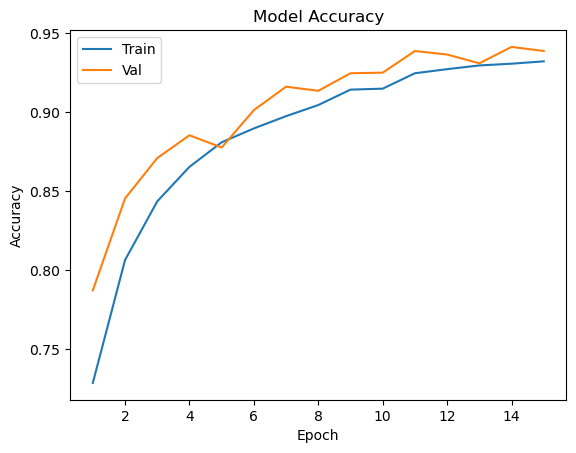

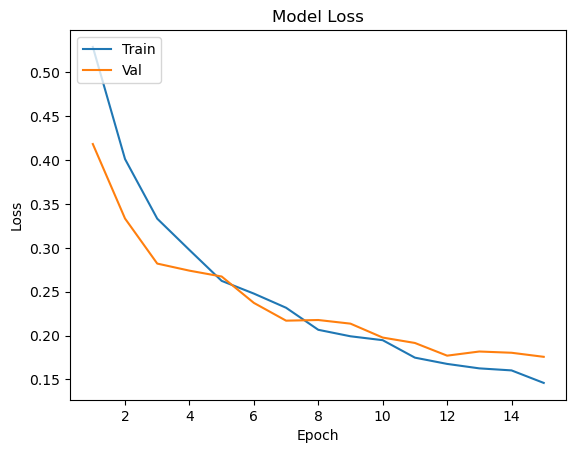

In [134]:
plot_learning_curve(history_filtered, NUMBER_OF_EPOCHS)

In [135]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn_filtered = np.argmax(cnn_model_filtered.predict(X_raw_filtered_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_filtered_test, predicted_cnn_filtered))
print(accuracy_score(y_raw_filtered_test, predicted_cnn_filtered))
print(f1_score(y_raw_filtered_test, predicted_cnn_filtered, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

85/85 [==============================] - 0s 3ms/step
[[1293   59]
 [ 107 1244]]
0.9385867554568997
0.9385867554568997


In [136]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_filtered_test, predicted_cnn_filtered))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1352
           1       0.95      0.92      0.94      1351

    accuracy                           0.94      2703
   macro avg       0.94      0.94      0.94      2703
weighted avg       0.94      0.94      0.94      2703



In [137]:
results_filtered = cnn_model_filtered.evaluate(X_raw_filtered_test, y_raw_filtered_test)
print("test loss, test acc: ", results_filtered)

85/85 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9386
test loss, test acc:  [0.17573325335979462, 0.9385867714881897]


In [204]:
cnn_filtered_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_filtered_train, y_raw_filtered_train, X_raw_filtered_train[0].shape, NUMBER_OF_EPOCHS, 5)
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_filtered_cv_metrics)

0.939819085597992


## III - Filtered and Normalised

In [138]:
df_binary_combined_filtered_normalised = feature_util_UPFall.normalise_df(df_binary_combined_filtered.drop(['outcome'], axis=1))
df_binary_combined_filtered_normalised['outcome'] = df_binary_combined_filtered['outcome']
df_binary_combined_filtered_normalised

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,outcome
0,0.342280,0.395239,0.569756,0.414420,0.503240,0.582203,1
1,0.328154,0.393832,0.571100,0.436878,0.513690,0.604337,1
2,0.296528,0.384230,0.571769,0.446508,0.528152,0.619588,1
3,0.280850,0.381679,0.568642,0.449625,0.530032,0.585209,1
4,0.309602,0.396962,0.564188,0.451869,0.512113,0.493265,1
...,...,...,...,...,...,...,...
294673,0.482159,0.492373,0.616383,0.443908,0.481392,0.398619,0
294674,0.482580,0.492422,0.616059,0.444348,0.481040,0.398623,0
294675,0.483554,0.493055,0.615580,0.444464,0.480968,0.398894,0
294676,0.483649,0.493335,0.615281,0.443988,0.480805,0.399036,0


In [139]:
X_filtered_normalised, y_filtered_normalised = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_filtered_normalised, frame_size, hop_size, True)
features_filtered_normalised = feature_util_UPFall.extract_features_with_gyro(X_filtered_normalised)
features_filtered_normalised.shape

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


(6405, 22)

In [140]:
feature_filtered_normalised_df = pd.DataFrame(features_filtered_normalised)

y_filtered_normalised_df = pd.DataFrame(y_filtered)
y_filtered_normalised_df = y_filtered_normalised_df.rename(mapper={0:"outcome"}, axis=1)
y_filtered_normalised_df
feature_and_outcome_filtered_normalised_df = pd.concat([feature_filtered_normalised_df, y_filtered_normalised_df], axis=1)

In [141]:
sm = SMOTE(random_state=42)

X_filtered_normalised_res, y_filtered_normalised_res = sm.fit_resample(feature_filtered_normalised_df, y_filtered_normalised_df)
y_filtered_normalised_res.value_counts()

outcome
0          5406
1          5406
dtype: int64

In [142]:
X_filtered_normalised_train, X_filtered_normalised_test, y_filtered_normalised_train, y_filtered_normalised_test = train_test_split(X_filtered_normalised_res, y_filtered_normalised_res, test_size=0.25, random_state=0, stratify=y_filtered_normalised_res)

In [143]:
X_filtered_normalised_train.shape, X_filtered_normalised_test.shape, y_filtered_normalised_train.shape, y_filtered_normalised_test.shape

((8109, 22), (2703, 22), (8109, 1), (2703, 1))

In [144]:
unique, counts = np.unique(y_filtered_train, return_counts=True)
dict(zip(unique, counts))

{0: 4054, 1: 4055}

### Traditional Machine Learning Methods

In [145]:
filtered_normalised_model_name_array = []
filtered_normalised_model_acc_array = []

In [146]:
knn_model_filtered_normalised = KNeighborsClassifier(n_neighbors=5)
knn_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [147]:
# Predict on the test set
predicted_knn_filtered_normalised = knn_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_knn_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_knn_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_knn_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("knn")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_knn_filtered_normalised))

[[1146  206]
 [  58 1293]]
0.902330743618202
0.902330743618202


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [148]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [149]:
svm_model_filtered_normalised = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [150]:
# Predict on the test set
predicted_svm_filtered_normalised = svm_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_svm_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_svm_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_svm_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("svm")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_svm_filtered_normalised))

[[1078  274]
 [ 495  856]]
0.7155012948575656
0.7155012948575658


In [151]:
svm_rbf_model_filtered_normalised = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [152]:
# Predict on the test set
predicted_svm_rbf_filtered_normalised = svm_rbf_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("svm_rbf")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))

[[1150  202]
 [ 549  802]]
0.7221605623381429
0.7221605623381429


In [153]:
rf_model_filtered_normalised = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model_filtered_normalised.fit(X_filtered_train, y_filtered_normalised_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_29220\1829240526.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_filtered_normalised.fit(X_filtered_train, y_filtered_normalised_train)


RandomForestClassifier(random_state=42)

In [154]:
# Predict on the test set
predicted_rf_filtered_normalised = rf_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_rf_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_rf_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_rf_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("rf")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_rf_filtered_normalised))

[[749 603]
 [980 371]]
0.41435442101368847
0.41435442101368847


In [155]:
nb_model_filtered_normalised = GaussianNB()
nb_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [156]:
# Predict on the test set
predicted_nb_filtered_normalised = nb_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_nb_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_nb_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_nb_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("nb")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_nb_filtered_normalised))

[[1202  150]
 [ 842  509]]
0.6330003699593045
0.6330003699593045


In [157]:
best_trad_model_acc_filtered_normalised = max(filtered_normalised_model_acc_array)
index = filtered_normalised_model_acc_array.index(max(filtered_normalised_model_acc_array))
best_trad_model_filtered_normalised = filtered_normalised_model_name_array[index]
print(f"Best model: {best_trad_model_filtered_normalised}, Accuracy: {best_trad_model_acc_filtered_normalised}")

Best model: knn, Accuracy: 0.902330743618202


In [158]:
for i in range(0, len(filtered_normalised_model_name_array)):
    print(f"name: {filtered_normalised_model_name_array[i]}, accuracy: {filtered_normalised_model_acc_array[i]}")

name: knn, accuracy: 0.902330743618202
name: svm, accuracy: 0.7155012948575656
name: svm_rbf, accuracy: 0.7221605623381429
name: rf, accuracy: 0.41435442101368847
name: nb, accuracy: 0.6330003699593045


In [159]:
filtered_normalised_model_dictionary = {"knn": knn_model_filtered_normalised,
                             "svm": svm_model_filtered_normalised,
                             "svm_rbf": svm_rbf_model_filtered_normalised,
                             "rf": rf_model_filtered_normalised,
                             "nb": nb_model_filtered_normalised}

In [160]:
scores_array_filtered_normalised = perform_cross_val_all_models(filtered_normalised_model_dictionary, X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [161]:
for cv_tuple in scores_array_filtered_normalised:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.90 (+/- 0.01)
svm Accuracy: 0.72 (+/- 0.03)
svm_rbf Accuracy: 0.73 (+/- 0.02)
rf Accuracy: 0.93 (+/- 0.01)
nb Accuracy: 0.64 (+/- 0.02)


In [162]:
print_all_classification_reports(filtered_normalised_model_dictionary, X_filtered_normalised_test, y_filtered_normalised_test)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1352
           1       0.86      0.96      0.91      1351

    accuracy                           0.90      2703
   macro avg       0.91      0.90      0.90      2703
weighted avg       0.91      0.90      0.90      2703

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1352
           1       0.76      0.63      0.69      1351

    accuracy                           0.72      2703
   macro avg       0.72      0.72      0.71      2703
weighted avg       0.72      0.72      0.71      2703

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1352
           1       0.80      0.59      0.68      1351

    accuracy                           0.72      2703
   macro avg       0.74      0.72      0.72      2703
weighted a

In [163]:
print_all_classification_reports_training(filtered_normalised_model_dictionary, X_filtered_normalised_train, y_filtered_normalised_train)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4054
           1       0.90      0.98      0.94      4055

    accuracy                           0.93      8109
   macro avg       0.94      0.93      0.93      8109
weighted avg       0.94      0.93      0.93      8109

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      4054
           1       0.76      0.64      0.69      4055

    accuracy                           0.72      8109
   macro avg       0.72      0.72      0.71      8109
weighted avg       0.72      0.72      0.71      8109

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.68      0.85      0.76      4054
           1       0.81      0.61      0.69      4055

    accuracy                           0.73      8109
   macro avg       0.75      0.73      0.73      8109
weighted a

In [164]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/rf_filtered_normalised.joblib')

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [165]:
X_raw_filtered_normalised_smote, y_raw_filtered_normalised_smote = feature_util_UPFall.generate_windows_SMOTE(X_filtered_normalised, y_filtered_normalised)
X_raw_filtered_normalised_smote.shape, y_raw_filtered_normalised_smote.shape

((10812, 92, 6), (10812,))

In [166]:
# X_raw_filtered_normalised_train, X_raw_filtered_normalised_test, y_raw_filtered_normalised_train, y_raw_filtered_normalised_test = train_test_split(X_filtered_normalised, y_filtered_normalised, test_size=0.25, random_state=0, stratify=y_filtered_normalised)
X_raw_filtered_normalised_train, X_raw_filtered_normalised_test, y_raw_filtered_normalised_train, y_raw_filtered_normalised_test = train_test_split(X_raw_filtered_normalised_smote, y_raw_filtered_normalised_smote, test_size=0.25, random_state=0, stratify=y_raw_filtered_normalised_smote)
X_raw_filtered_normalised_train.shape, X_raw_filtered_normalised_test.shape, y_raw_filtered_normalised_train.shape

((8109, 92, 6), (2703, 92, 6), (8109,))

In [167]:
X_raw_filtered_normalised_train[0].shape

(92, 6)

In [168]:
X_raw_filtered_normalised_train = X_raw_filtered_normalised_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_filtered_normalised_test = X_raw_filtered_normalised_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [169]:
X_raw_filtered_normalised_train[0].shape, X_raw_filtered_normalised_test[0].shape

((92, 6, 1), (92, 6, 1))

In [170]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [171]:
cnn_model_filtered_normalised = Sequential()
cnn_model_filtered_normalised.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_filtered_normalised_train[0].shape))
cnn_model_filtered_normalised.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model_filtered_normalised.add(Flatten())
cnn_model_filtered_normalised.add(Dense(64, activation='relu'))
cnn_model_filtered_normalised.add(Dense(2, activation='softmax'))

In [172]:
cnn_model_filtered_normalised.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [173]:
history_filtered_normalised = cnn_model_filtered_normalised.fit(X_raw_filtered_normalised_train, y_raw_filtered_normalised_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_filtered_normalised_test, y_raw_filtered_normalised_test), verbose=1)

Epoch 1/15
254/254 [==============================] - 5s 16ms/step - loss: 0.6888 - accuracy: 0.5101 - val_loss: 0.6774 - val_accuracy: 0.5505
Epoch 2/15
254/254 [==============================] - 3s 14ms/step - loss: 0.6637 - accuracy: 0.5606 - val_loss: 0.6782 - val_accuracy: 0.5087
Epoch 3/15
254/254 [==============================] - 4s 16ms/step - loss: 0.6403 - accuracy: 0.5967 - val_loss: 0.6105 - val_accuracy: 0.6722
Epoch 4/15
254/254 [==============================] - 4s 17ms/step - loss: 0.5780 - accuracy: 0.6748 - val_loss: 0.6212 - val_accuracy: 0.5938
Epoch 5/15
254/254 [==============================] - 4s 17ms/step - loss: 0.5298 - accuracy: 0.7129 - val_loss: 0.5104 - val_accuracy: 0.7211
Epoch 6/15
254/254 [==============================] - 4s 18ms/step - loss: 0.4812 - accuracy: 0.7408 - val_loss: 0.4993 - val_accuracy: 0.7321
Epoch 7/15
254/254 [==============================] - 4s 16ms/step - loss: 0.4511 - accuracy: 0.7673 - val_loss: 0.5463 - val_accuracy: 0.7155

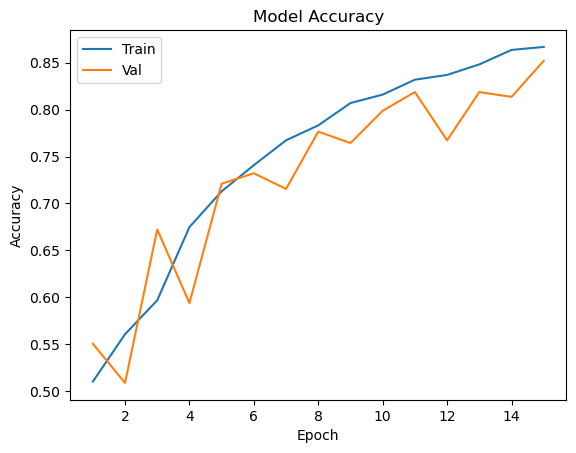

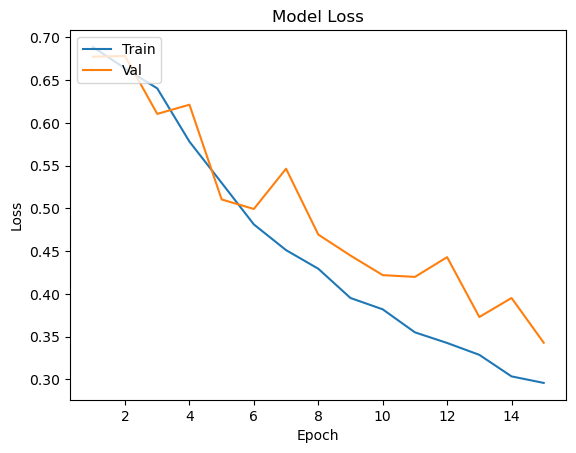

In [174]:
plot_learning_curve(history_filtered_normalised, NUMBER_OF_EPOCHS)

In [175]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn_filtered_normalised = np.argmax(cnn_model_filtered_normalised.predict(X_raw_filtered_normalised_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))
print(accuracy_score(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))
print(f1_score(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

85/85 [==============================] - 0s 3ms/step
[[1190  162]
 [ 238 1113]]
0.852016278209397
0.852016278209397


In [176]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1352
           1       0.87      0.82      0.85      1351

    accuracy                           0.85      2703
   macro avg       0.85      0.85      0.85      2703
weighted avg       0.85      0.85      0.85      2703



In [177]:
results_filtered_normalised = cnn_model_filtered.evaluate(X_raw_filtered_normalised_test, y_raw_filtered_normalised_test)
print("test loss, test acc: ", results_filtered_normalised)

85/85 [==============================] - 0s 3ms/step - loss: 0.7481 - accuracy: 0.4750
test loss, test acc:  [0.7481103539466858, 0.47502774000167847]


In [205]:
cnn_filtered_normalised_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_filtered_normalised_train, y_raw_filtered_normalised_train, X_raw_filtered_normalised_train[0].shape, NUMBER_OF_EPOCHS, 5)
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_filtered_normalised_cv_metrics)

0.8216768145561218
